In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=8

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=8


In [2]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from inference_img import _build_model, _build_dataloader, split, merge

In [3]:
cfg = "../configs/bpr/hrnet18s_128.py"
ckpt = "../ckpts/hrnet18s_128-24055c80.pth"
max_ins = 32         # set to lower value to save GPU memory
model = _build_model(cfg, ckpt)

def _inference_one(img, sub_maskdts, sub_dt_paths):
    dets, patches = split(img, sub_maskdts)
    masks = model(patches)[:,1,:,:]                 # N, 128, 128
    refineds = merge(sub_maskdts, dets, masks)
    out = []
    for i, dt_path in enumerate(sub_dt_paths):
        out.append(refineds[i].cpu().numpy().astype(np.uint8) * 255)
    return out

In [4]:
img_paths = ['lindau_000000_000019_leftImg8bit.png']
mask_paths = [['lindau_000000_000019_leftImg8bit_15_car.png'], ]

dataloader = _build_dataloader(img_paths, mask_paths, device='cuda:0')

for dc in dataloader:
    dt_paths, img, maskdts = dc.data[0][0]
    img = img.cuda()
    maskdts = maskdts.cuda()

    p = 0
    for sub_maskdts in maskdts.split(max_ins):
        q = p + sub_maskdts.size(0)
        sub_dt_paths = dt_paths[p:q]
        p = q
        refine_mask = _inference_one(img, sub_maskdts, sub_dt_paths)

/home/chenhang/data/anaconda3/envs/mmseg/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


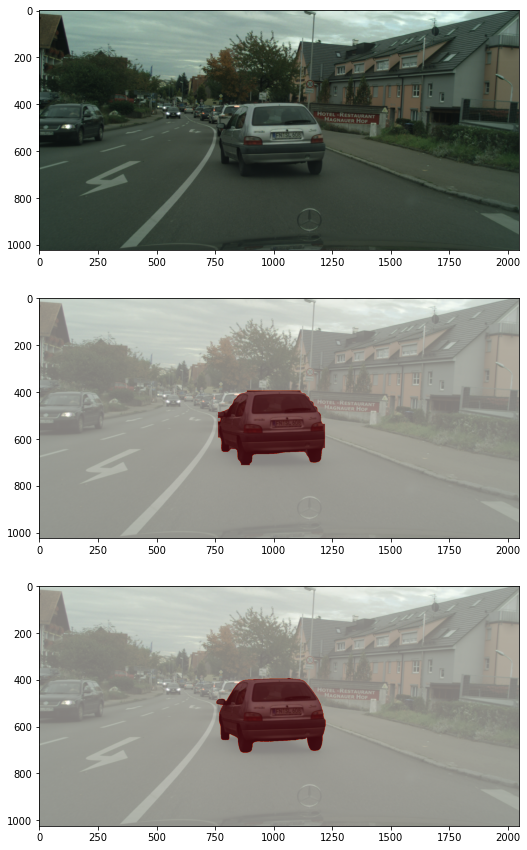

In [5]:

img = cv2.imread(img_paths[0])[:,:,::-1]
coarse_mask = cv2.imread(mask_paths[0][0], 0)

fig, axs = plt.subplots(3, 1, figsize=(20, 15))
axs[0].imshow(img)
axs[1].imshow(img)
axs[1].imshow(coarse_mask, alpha=0.5, cmap="Reds")
axs[2].imshow(img)
axs[2].imshow(refine_mask[0], alpha=0.5, cmap="Reds")